In [407]:
# importing package
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

(100.0, 10000000.0)

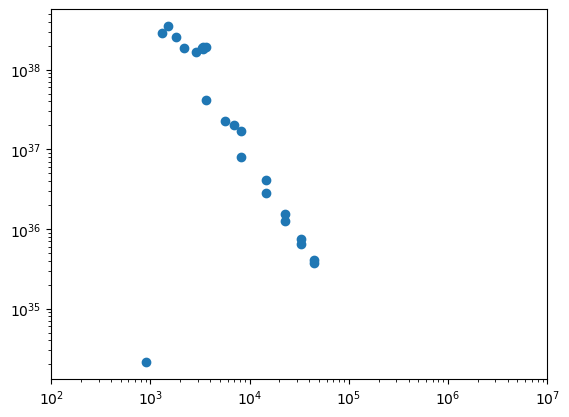

In [408]:
# Trying equation
phot_912 = 52.86800
alphab = 2.6e-13
gamma = np.array([0.,0.,2.11e-4,5.647,9.35,9.847,10.582,16.101,24.681,26.736,24.883,29.979,6.519,8.773,11.545,13.585,6.333,10.444,7.023,9.361,7.59,9.35,8.32,9.53,8.87,0.])
x_range = np.array([10.,912.,913.,1300.,1500.,1800.,2200.,2855.,3331.,3421.,3422.,3642.,3648.,5700.,7000.,8207.,8209.,14583.,14585.,22787.,22789.,32813.,32815.,44680.,44682.,2000000.])
def continuum_equation(): # in erg/s/A
  return 2.998e18/((x_range)**2 * alphab) * 1e-30 * gamma * 10.**(phot_912-10)
plt.plot(x_range, continuum_equation(), "o")
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e2, 1e7)

In [409]:
!pip install pyneb

In [410]:
import pickle
import sys
import numpy as np
from scipy.interpolate import interp1d
from scipy import optimize

import pyneb as pn
from pyneb import log_
#from ..utils.physics import CST
#from ..utils.misc import ROOT_DIR



class Continuum(object):
    
    def __init__(self):
        """Part of the PyNeb library.
        
        Mainly based on pySSN library        
        Adapted by V. Gomez-Llanos and C. Morisset, 2018
        """
        self.BE = None
        self.__HI_case = None
        self._set_HI_case('B')
        self.log_ = log_

        
    def _set_HI_case(self, case='B'):
        """Define the case (A or B) to be used for HI normalization line.
        
        Not sure that the Free-bound coefficients from Ercolano & Storey 2006 take case A option into account.
        
        Parameters:
            case (string): 'A' or 'B'
        """            
        if case != self.__HI_case:
            if case == 'A':
                pn.atomicData.setDataFile('h_i_rec_SH95-caseA.hdf5')
                self.HI = None
            elif case == 'B':
                pn.atomicData.setDataFile('h_i_rec_SH95.hdf5')
                self.HI = None
            else:
                raise ValueError('Unkown case {}. Should be A or B'.format(case))
            self.__HI_case = case
        
    def make_cont_Ercolano(self, tem, case, wl):
        """Adapted from http://adsabs.harvard.edu/abs/2006MNRAS.372.1875E
        
        Parameters:
            tem : electron temperature [K]. Can not be an array. 
                  In case of tem array, use get_continuum
            case: one of "H", "He1", "He2"
            wl: wavelength [Angstrom]. May be a float or a numpy array
        
        Returns:
            The continuum [erg/s.cm3/A]
        """
        try:
            _ = (e for e in wl)
        except TypeError:
            wl = np.array([wl])

        n_wl = len(wl)
        hnu =  CST.CLIGHT * 1e8 / wl * CST.HPLANCK  #!phy.c_ang_sec/wl*!phy.h
        if case == 'H':
            tab_T = 10**np.array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2,
                                  3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5,
                                  4.6, 4.7, 4.8, 4.9, 5. ])
            D = np.loadtxt(ROOT_DIR + '/' + 'atomic_data/coeff_ercolano_H.txt')
        elif case == 'He1':
            tab_T = 10**np.array([2.  , 2.04, 2.08, 2.12, 2.16, 2.2 , 2.24, 2.28, 2.32, 2.36, 2.4 ,
                                  2.44, 2.48, 2.52, 2.56, 2.6 , 2.64, 2.68, 2.72, 2.76, 2.8 , 2.84,
                                  2.88, 2.92, 2.96, 3.  , 3.04, 3.08, 3.12, 3.16, 3.2 , 3.24, 3.28,
                                  3.32, 3.36, 3.4 , 3.44, 3.48, 3.52, 3.56, 3.6 , 3.64, 3.68, 3.72,
                                  3.76, 3.8 , 3.84, 3.88, 3.92, 3.96, 4.  , 4.04, 4.08, 4.12, 4.16,
                                  4.2 , 4.24, 4.28, 4.32, 4.36, 4.4 , 4.44, 4.48, 4.52, 4.56, 4.6 ,
                                  4.64, 4.68, 4.72, 4.76, 4.8 , 4.84, 4.88, 4.92, 4.96, 5.  ])
            D = np.loadtxt(ROOT_DIR + '/' + 'atomic_data/coeff_ercolano_He1.txt')
        elif case == 'He2':
            tab_T = 10**np.array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2,
                                  3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5,
                                  4.6, 4.7, 4.8, 4.9, 5. ])
            D = np.loadtxt(ROOT_DIR + '/' + 'atomic_data/coeff_ercolano_He2.txt')
        else:
            self.log_.warn('Invalid case {0}'.format(case), calling='Continuum.make_cont_Ercolano')
            return np.nan
        if (tem < np.min(tab_T)).any() or (tem > np.max(tab_T)).any():
            self.log_.warn('Invalid temperature {0}'.format(tem), calling='Continuum.make_cont_Ercolano')            
            return np.nan
        
        BE_E_Ry = D[:,1]
        BE_E_erg = BE_E_Ry * CST.RYD_erg
        BE_E_Thr = BE_E_erg[D[:,0] == 1]
        Delta_E = np.zeros(n_wl)
        for i in np.arange(n_wl):
            DE = hnu[i] - BE_E_Thr
            Delta_E[i] = np.min(DE[DE > 0])
            
        n_T_sup = np.min(np.where(tab_T >= tem)[0])
        n_T_inf = n_T_sup - 1
        T_sup = tab_T[n_T_sup]
        T_inf = tab_T[n_T_inf]
        
        BE_coeff_sup = D[:, n_T_sup+2]
        BE_coeff_inf = D[:, n_T_inf+2]
        
        coeff_sup = interp1d(BE_E_erg, BE_coeff_sup)(hnu)
        coeff_inf = interp1d(BE_E_erg, BE_coeff_inf)(hnu)

        C_interp= (np.log10(tem) - np.log10(T_inf)) / (np.log10(T_sup) - np.log10(T_inf))
        
        coeff = coeff_sup * C_interp + coeff_inf*(1. - C_interp)
        
        cont = coeff * 1e-34 * tem**(-1.5) * np.exp(-Delta_E / tem / CST.BOLTZMANN) / wl**2. * CST.CLIGHT * 1e8 # erg/s.cm3/A
        return cont.squeeze()

    def two_photon(self, tem, den, wl):
        """
        Parameters:
            tem: temperature [K]. May be a float or a numpy array
            den: density [cm-3]
            wl: wavelength [Angstrom]. May be a float or a numpy array
            
        Returns:
            2 photons continuum [erg/s.cm3/A]
        """
        #ToDo : See Schirmer, M. 2016, PASP, 128, 114001 
        try:
            _ = (e for e in wl)
        except TypeError:
            wl = np.array([wl])
        y = 1215.7 / wl
        A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)
        mask = y > 1.0 # Thanks to Daniel Schaerer for pointing out this potential issue
        A[mask] = 0.
        alfa_eff = 0.838e-13 * (tem / 1e4)**(-0.728) # fit DP de Osterbrock
        q = 5.31e-4 * (tem / 1e4)**(-0.17) # fit DP de Osterbrock
        n_crit = 8.226 / q
        twophot_cont = CST.HPLANCK * CST.CLIGHT * 1e8 / wl**3. * 1215.7 * A / 8.226 * alfa_eff / \
                       (1. + den/n_crit)                
        #twophot_cont[~np.isfinite(twophot_cont)] = 0.
        return twophot_cont
            
    def gff(self, Z, tem, wl):
        """Adaptated from http://adsabs.harvard.edu/abs/1991CoPhC..66..129S
        
        Parameters:
            Z: atomic number
            tem: temperature [K]
            wk: wavelength [Angstrom]
        """
        D= np.array([8.986940175e+00, -4.009515855e+00,  8.808871266e-01,
            2.640245111e-02, -4.580645915e-02, -3.568055702e-03,   
            2.827798067e-03,  3.365860195e-04, -8.006936989e-01,
            9.466021705e-01,  9.043402532e-02, -9.608451450e-02,
            -1.885629865e-02,  1.050313890e-02,  2.800889961e-03, 
            -1.078209202e-03, -3.781305103e-01,  1.102726332e-01, 
            -1.543619180e-02,  8.310561114e-03,  2.179620525e-02, 
            4.259726289e-03, -4.181588794e-03, -1.770208330e-03,   
            1.877213132e-02, -1.004885705e-01, -5.483366378e-02,   
            -4.520154409e-03,  8.366530426e-03,  3.700273930e-03, 
            6.889320423e-04,  9.460313195e-05,  7.300158392e-02,   
            3.576785497e-03, -4.545307025e-03, -1.017965604e-02,   
            -9.530211924e-03, -3.450186162e-03,  1.040482914e-03, 
            1.407073544e-03, -1.744671550e-03,  2.864013856e-02,   
            1.903394837e-02,  7.091074494e-03, -9.668371391e-04,   
            -2.999107465e-03, -1.820642230e-03, -3.874082085e-04, 
            -1.707268366e-02, -4.694254776e-03,  1.311691517e-03, 
            5.316703136e-03,  5.178193095e-03,  2.451228935e-03,   
            -2.277321615e-05, -8.182359057e-04,  2.567331664e-04, 
            -9.155339970e-03, -6.997479192e-03, -3.571518641e-03, 
            -2.096101038e-04,  1.553822487e-03,  1.509584686e-03, 
            6.212627837e-04,  4.098322531e-03,  1.635218463e-03,   
            -5.918883504e-04, -2.333091048e-03, -2.484138313e-03, 
            -1.359996060e-03, -5.371426147e-05,  5.553549563e-04, 
            3.837562402e-05,  2.938325230e-03,  2.393747064e-03,   
            1.328839809e-03,  9.135013312e-05, -7.137252303e-04,   
            -7.656848158e-04, -3.504683798e-04, -8.491991820e-04, 
            -3.615327726e-04,  3.148015257e-04,  8.909207650e-04, 
            9.869737522e-04,  6.134671184e-04,  1.068883394e-04,   
            -2.046080100e-04 ])
    
        try:
            _ = (e for e in wl)
        except TypeError:
            wl = np.array([wl])
    
    
        XLF = np.log10(CST.CLIGHT * 1e8 / wl)
        N_wl = len(wl)
        G = np.zeros(N_wl)
        D = D.reshape(11, 8)
        B = np.zeros(11)
        C = np.zeros(8)
    
        XLRKT = 5.1983649 - np.log10(tem)
        TXG = 0.66666667 * (2.0 * np.log10(Z) + XLRKT)
    
        for j in np.arange(7):
            B[10] = D[10, j]
            B[9] = TXG * B[10] + D[9, j]
            for IR in np.arange(8)[::-1]:
                B[IR] = TXG * B[IR+1] - B[IR+2] + D[IR, j]
            C[j] = 0.25 * (B[0] - B[2])               
    
    
        CON=0.72727273 * XLRKT - 10.376127  
    
        for i in np.arange(N_wl):
            TXU = 0.72727273 * XLF[i] + CON 
            B[7] = C[7]
            B[6] = TXU * B[7] + C[6] 
            for IR in np.arange(5)[::-1]: 
                B[IR] = TXU * B[IR+1] - B[IR+2] + C[IR]
            G[i] = B[0] - B[2]
    
        return G.squeeze()

    def FreeFree(self, tem, wl, He1_H=0., He2_H=0., tem_HeI=None, tem_HeII=None):
        """
        Parameters:
            tem:
            wl:
            He1_H (float) default: 0.
            He2_H (float) default: 0.
            tem_HeI (float) default: None.
            tem_HeII (float) default: None.
        """
        if tem_HeI is None:
            tem_HeI = tem
        if tem_HeII is None:
            tem_HeII = tem
            
        gff_HI = self.gff(1., tem, wl)
        gff_HeI = self.gff(1., tem_HeI, wl)
        gff_HeII = self.gff(4., tem_HeII, wl)

        FF_cont = (6.8391014e-38 * CST.CLIGHT * 1e8 / wl**2. * (
                        1.0**2. / np.sqrt(tem) * np.exp(-CST.HPLANCK*CST.CLIGHT*1e8/wl/CST.BOLTZMANN/tem) * gff_HI + 
                        He1_H * 1.0**2./ np.sqrt(tem_HeI) * np.exp(-CST.HPLANCK*CST.CLIGHT*1e8/wl/CST.BOLTZMANN/tem_HeI) * gff_HeI  + 
                        He2_H* 2.0**2. / np.sqrt(tem_HeII) * np.exp(-CST.HPLANCK*CST.CLIGHT*1e8/wl/CST.BOLTZMANN/tem_HeII) * gff_HeII))
        return FF_cont
    
    def _get_continuum1(self, tem, den, He1_H=0., He2_H=0., wl=None, 
                      cont_HI=True, cont_HeI=True, cont_HeII=True, 
                      cont_2p=True, cont_ff=True):
        """
        Type of continuum to take into acount defined a boolean, defaults are True
        
        Parameters:
            tem: temperature [K]. May be a float or an iterable
            den: density [cm-3]. May be a float or an iterable. If iterable, must have same size than tem
            He1_H and He2_H: He+/H+ and He++/H+ abundances. Default = 0.0
            wl: wavelengths: May be an array
            cont_HI (bool) default: True
            cont_HeI (bool) default: True
            cont_HeII (bool) default:True using B. Ercolano 2006 data
            cont_2p (bool) default: True 2 photons, using D. Pequignot fit to Osterbrock
            cont_ff (bool) default: 
            
        Returns:
            The resulting continuum [erg/s.cm3/A]
        """

        cont = 0.
        if cont_HI:
            cont += self.make_cont_Ercolano(tem = tem, case = 'H', wl = wl)
        if cont_HeI and He1_H > 0.:
            cont += He1_H * self.make_cont_Ercolano(tem = tem, case = 'He1', wl = wl)
        if cont_HeII and He2_H > 0:
            cont += He2_H * self.make_cont_Ercolano(tem = tem, case = 'He2', wl = wl)
        if cont_2p:
            cont += self.two_photon(tem = tem, den = den, wl = wl)
        if cont_ff:
            cont += self.FreeFree(tem = tem, wl = wl, He1_H=He1_H, He2_H=He2_H)
        
        return cont

    def get_continuum(self, tem, den, He1_H=0., He2_H=0., wl=np.array([3500, 3600, 3700, 3800, 3900]), 
                      cont_HI=True, cont_HeI=True, cont_HeII=True, 
                      cont_2p=True, cont_ff=True, HI_label='11_2'):
        """
        
        Type of continuum to take into acount defined a boolean, defaults are True
        
        Parameters:
            tem: temperature [K]. May be a float or an iterable.
            den: density [cm-3]. May be a float or an iterable. If iterable, must have same size than tem.
            He1_H (float):  He+/H+ abundance. Default = 0.0
            He2_H (float): He++/H+ abundances.  Default = 0.0
            wl (np.array): Wavelengths Default = np.array([3500, 3600, 3700, 3800, 3900])
            cont_HI (bool): using B. Ercolano 2006 data. Default: True
            cont_HeI (bool): using B. Ercolano 2006 data. Default: True
            cont_HeII (bool): using B. Ercolano 2006 data. Default: True
            cont_2p (bool): 2 photons, using D. Pequignot fit to Osterbrock. Default: True
            cont_ff (bool): from Storey & Hummer 1991. Default: True
            
            HI_label (str): HI label to normalize the continuum. If None, no normalization is done. Default: '11_2'
            
        Returns:
            The resulting continuum. Unit [A-1] if normalized, [erg/s.cm3/A] otherwise
        
        Exemple of use:
            C = pn.Continuum()
            wl = np.arange(3500, 4000, 1)
            cont = C.get_continuum(tem=1e4, den=1e2, He1_H=0.08, He2_H=0.02, wl=wl)
            plt.plot(wl, cont)
        """
        try:
            _ = (e for e in tem)
            T_iterable = True
            try:
                _ = (e for e in den)
            except:
                den = np.ones_like(tem) * den
            try:
                _ = (e for e in He1_H)
            except:
                He1_H = np.ones_like(tem) * He1_H
            try:
                _ = (e for e in He2_H)
            except:
                He2_H = np.ones_like(tem) * He2_H
            
        except TypeError:
            T_iterable = False
        if HI_label is None:
            norm = 1.0
        else:
            if self.HI is None:
                self.HI = pn.RecAtom('H',1)
            norm = self.HI.getEmissivity(tem, den, label = HI_label, product=False)
            
        if T_iterable:
            cont = np.array(list(map(lambda t, d, He1_H_1,He2_H_1 : self._get_continuum1(t, d, 
                                                                                  He1_H=He1_H_1, 
                                                                                  He2_H=He2_H_1, 
                                                                                  wl=wl, 
                                                                                  cont_HI=cont_HI, 
                                                                                  cont_HeI=cont_HeI, 
                                                                                  cont_HeII=cont_HeII, 
                                                                                  cont_2p=cont_2p, 
                                                                                  cont_ff=cont_ff), 
                                     tem, den, He1_H, He2_H))).T
            return cont.squeeze()/norm
        else:
            cont = self._get_continuum1(tem, den, He1_H=He1_H, He2_H=He2_H, wl=wl, 
                                        cont_HI=cont_HI, cont_HeI=cont_HeI, cont_HeII=cont_HeII, 
                                        cont_2p=cont_2p, cont_ff=cont_ff)
            return cont/norm
    
    def BJ_HI(self, tem, den, He1_H, He2_H, wl_bbj = 3643, wl_abj = 3861, HI_label='11_2'):
        """
        Parameters:
            tem: temperature [K]. May be a float or an iterable
            den: density [cm-3]. May be a float or an iterable. If iterable, must have same size than tem
            He1_H: He+/H+ abundances.
            He2_H: He++/H+ abundances.
        
            wl_bbj (int): wavelengths below the jump resp. Default: 3643
            wl_abj (int): wavelengths above the jump resp. Defaults: 3861
            HI_label (str): reference HI line to normalize the jump. Default is 11_2
        
        Returns:
            The Balmer Jump (may be any other jump if wl are changed) normalized to the HI line
        """
        
        fl_bbj, fl_abj = self.get_continuum(tem = tem, den = den, He1_H = He1_H, 
                                            He2_H = He2_H, wl = np.array([wl_bbj, wl_abj]),
                                            HI_label=HI_label)
        
        BJ_HI = fl_bbj - fl_abj
        return BJ_HI
    
    def T_BJ(self, BJ_HI, den, He1_H, He2_H, wl_bbj = 3643, wl_abj = 3861, HI_label='11_2',
             T_min=5e2, T_max=3e4):
        """
        Parameters:
            BJ_HI: Balmer Jump (may be any other jump if wl are changed) normalized to the HI line
            den: density [cm-3]. May be a float or an iterable. If iterable, must have same size than tem
            He1_H: He+/H+ abundances.
            He2_H: He++/H+ abundances.
            wl_bbj (int): wavelengths below the jump resp. Default: 3643
            wl_abj (int): wavelengths above the jump resp. Defaults: 3861
            HI_label: reference HI line to normalize the jump. Default: 11_2
        
            T_min: minimum temperature [K] for the root finding exploration. Default: 5e2
            T_max: maximum temperature [K] for the root finding exploration. Default: 3e4
        
        Returns:
            Temperature [K] corresponding to the jump
        """
        try:
            _ = (e for e in BJ_HI)
            BJ_iterable = True
        except TypeError:
            BJ_iterable = False
            
        def f2minimize(tem, BJ_HI):
            f = self.BJ_HI(tem, den=den, He1_H=He1_H, He2_H=He2_H, wl_bbj = wl_bbj, wl_abj=wl_abj, HI_label=HI_label) - BJ_HI
            return f

        def f2minimize_i(tem, i):
            f = self.BJ_HI(tem, den=den.ravel()[i], He1_H=He1_H.ravel()[i], He2_H=He2_H.ravel()[i], 
                           wl_bbj = wl_bbj, wl_abj=wl_abj, HI_label=HI_label) - BJ_HI.ravel()[i]
            return f
            
        if BJ_iterable:
            T_BJ = np.array(list(map(lambda i: optimize.brentq(f2minimize_i, T_min, T_max, args=i), np.arange(len(BJ_HI.ravel()))))).T
            return T_BJ.squeeze()
        else:
            T_BJ = optimize.brentq(f2minimize, T_min, T_max, args=BJ_HI)
            return T_BJ

    
    def T_BJ_Liu(self, BJ_H11, He1_H, He2_H):
        """
        From Liu, X.-W., Luo, S.-G., Barlow, M. J., Danziger, I. J., & Storey, P. J.
        2001, MNRAS, 327, 141-168
        
        Parameters:
            BJ_H11: Balmer Jump normalized to the H11 line
            He1_H: He+/H+ abundances.
            He2_H: He++/H+ abundances.
        """
        T = 368 * (1 + 0.259 * He1_H + 3.409 * He2_H) * (BJ_H11)**(-3./2)
        return T

/Users/patsyp/anaconda3/lib/python3.11/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


Text(0, 0.5, '$4\\pi\\nu j_\\nu /(n_e n_p)$')

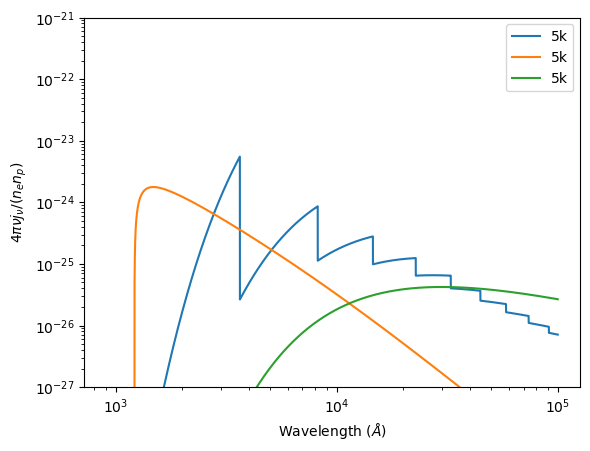

In [411]:
C = pn.Continuum()
wl1 = np.logspace(2.96, 5, 8000)
dense = 1e4
cont = C.get_continuum(tem = 5e3, den = dense, He1_H = 0, He2_H = 0, wl = wl1, HI_label = None, cont_HI=True, cont_HeI=True, cont_HeII=True, 
                      cont_2p=False, cont_ff=False)
plt.plot(wl1, cont * wl1, label = '5k')
wl = np.logspace(3, 5, 8000)
cont4 = C.get_continuum(tem = 5e3, den = dense, He1_H = 0, He2_H = 0, wl = wl, HI_label = None, cont_HI=False, cont_HeI=False, cont_HeII=False, 
                      cont_2p=True, cont_ff=False)
plt.plot(wl, cont4 * wl, label = '5k')
cont5 = C.get_continuum(tem = 5e3, den = dense, He1_H = 0, He2_H = 0, wl = wl, HI_label = None, cont_HI=False, cont_HeI=False, cont_HeII=False, 
                      cont_2p=False, cont_ff=True)
plt.plot(wl, cont5 * wl, label = '5k')
cont1 = C.get_continuum(tem = 1e4, den = dense, He1_H = 0, He2_H = 0, wl = wl, HI_label = None)
#plt.plot(wl, cont1 * wl, label = '10k')
cont2 = C.get_continuum(tem = 1.5e4, den = dense, He1_H = 0, He2_H = 0, wl = wl, HI_label = None)
#plt.plot(wl, cont2 * wl, label = '15k')
cont3 = C.get_continuum(tem = 2e4, den = dense, He1_H = 0, He2_H = 0, wl = wl, HI_label = None)
#plt.plot(wl, cont3 * wl, label = '20k')
plt.legend()
plt.ylim(1e-27, 1e-21)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel(r"$4\pi\nu j_\nu /(n_e n_p)$")

In [412]:
# Installing yt
!python -m pip install --upgrade pip
!python -m pip install --user yt

In [413]:
# Additional requirements
!python -m pip install --upgrade pip
!python -m pip install --user "yt[ramses]"

In [414]:
# Building from source
!apt-get install git
!apt-get install build-essential
!git clone https://github.com/yt-project/yt
%cd yt
!python -m pip install --upgrade pip
!python -m pip install --user -e .

zsh:1: command not found: apt-get
zsh:1: command not found: apt-get
fatal: destination path 'yt' already exists and is not an empty directory.
/Users/patsyp/yt/yt/yt/yt/yt/yt
Obtaining file:///Users/patsyp/yt/yt/yt/yt/yt/yt
ERROR: file:///Users/patsyp/yt/yt/yt/yt/yt/yt does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [415]:
# Leveraging optional yt runtime dependencies
!python -m pip install --user yt[full]
!python -m pip install --user -e .[full]

zsh:1: no matches found: yt[full]
zsh:1: no matches found: .[full]


In [416]:
# Testing
!python -c "import yt"

In [417]:
import yt
# Load the dataset.
ds = yt.load("/Users/patsyp/Desktop/output_00273")

yt : [INFO     ] 2024-05-29 21:37:00,478 Parameters: current_time              = 4.311420483661945
yt : [INFO     ] 2024-05-29 21:37:00,479 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-05-29 21:37:00,480 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-05-29 21:37:00,482 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-05-29 21:37:00,482 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-05-29 21:37:00,482 Parameters: current_redshift          = 12.171087046255657
yt : [INFO     ] 2024-05-29 21:37:00,482 Parameters: omega_lambda              = 0.685000002384186
yt : [INFO     ] 2024-05-29 21:37:00,483 Parameters: omega_matter              = 0.314999997615814
yt : [INFO     ] 2024-05-29 21:37:00,483 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-05-29 21:37:00,483 Parameters: hubble_constant           = 0.674000015258789


In [418]:
print(dir(ds.fields))
print(dir(ds.fields.ramses))

yt : [INFO     ] 2024-05-29 21:37:00,501 Detected RAMSES-RT file WITH IR trapping.
yt : [WARNING  ] 2024-05-29 21:37:00,556 Supposed that `particle_extra_field_1` has type |S1 given record size
yt : [WARNING  ] 2024-05-29 21:37:00,557 Supposed that `particle_extra_field_2` has type |S1 given record size
yt : [WARNING  ] 2024-05-29 21:37:00,557 Detected 4 extra particle fields assuming kind `double`. Consider using the `extra_particle_fields` keyword argument if you have unexpected behavior.
yt : [WARNING  ] 2024-05-29 21:37:00,567 This output has no cooling fields


['deposit', 'gas', 'gravity', 'index', 'io', 'nbody', 'ramses', 'ramses-rt', 'rt', 'sink', 'sink_csv']
['Density', 'HII', 'HeII', 'HeIII', 'Metallicity', 'Pres_IR', 'Pressure', 'cell_volume', 'dx', 'dy', 'dz', 'path_element_x', 'path_element_y', 'path_element_z', 'var_10', 'vertex_x', 'vertex_y', 'vertex_z', 'volume', 'x', 'x-velocity', 'y', 'y-velocity', 'z', 'z-velocity']


In [419]:
cell_fields = [
    "Density",
    "x-velocity",
    "y-velocity",
    "z-velocity",
    "Pressure",
    "Metallicity",
    # "dark_matter_density",
    "xHI",
    "xHII",
    "xHeII",
    "xHeIII",
]
epf = [
    ("particle_family", "b"),
    ("particle_tag", "b"),
    ("particle_birth_epoch", "d"),
    ("particle_metallicity", "d"),
]

f1 = "/Users/patsyp/Desktop/output_00273"

f2 = "output_00274/info_00274.txt"
ds = yt.load(f1, fields=cell_fields, extra_particle_fields=epf)
ad_psfc = pre_sfc_ds.all_data()

yt : [INFO     ] 2024-05-29 21:37:01,052 Parameters: current_time              = 4.311420483661945
yt : [INFO     ] 2024-05-29 21:37:01,052 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-05-29 21:37:01,052 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-05-29 21:37:01,053 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-05-29 21:37:01,053 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-05-29 21:37:01,053 Parameters: current_redshift          = 12.171087046255657
yt : [INFO     ] 2024-05-29 21:37:01,053 Parameters: omega_lambda              = 0.685000002384186
yt : [INFO     ] 2024-05-29 21:37:01,053 Parameters: omega_matter              = 0.314999997615814
yt : [INFO     ] 2024-05-29 21:37:01,053 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-05-29 21:37:01,053 Parameters: hubble_constant           = 0.674000015258789


In [420]:
print(dir(ds.fields))
print(dir(ds.fields.star))
#print(ds.fields.gas.density)

yt : [WARNING  ] 2024-05-29 21:37:01,085 This output has no cooling fields
yt : [WARNING  ] 2024-05-29 21:37:08,129 The DM particle filter already exists. Overriding.
yt : [WARNING  ] 2024-05-29 21:37:08,131 The star particle filter already exists. Overriding.
yt : [WARNING  ] 2024-05-29 21:37:08,132 The cloud particle filter already exists. Overriding.
yt : [WARNING  ] 2024-05-29 21:37:08,132 The dust particle filter already exists. Overriding.
yt : [WARNING  ] 2024-05-29 21:37:08,132 The star_tracer particle filter already exists. Overriding.
yt : [WARNING  ] 2024-05-29 21:37:08,132 The cloud_tracer particle filter already exists. Overriding.
yt : [WARNING  ] 2024-05-29 21:37:08,132 The dust_tracer particle filter already exists. Overriding.
yt : [WARNING  ] 2024-05-29 21:37:08,133 The gas_tracer particle filter already exists. Overriding.
yt : [INFO     ] 2024-05-29 21:37:08,133 Adding particle_type: DM
yt : [INFO     ] 2024-05-29 21:37:08,140 Adding particle_type: star
yt : [INFO  

['DM', 'cloud', 'cloud_tracer', 'deposit', 'dust', 'dust_tracer', 'gas', 'gas_tracer', 'gravity', 'index', 'io', 'nbody', 'ramses', 'ramses-rt', 'rt', 'sink', 'sink_csv', 'star', 'star_tracer']
['mesh_id', 'particle_angular_momentum', 'particle_angular_momentum_magnitude', 'particle_angular_momentum_x', 'particle_angular_momentum_y', 'particle_angular_momentum_z', 'particle_birth_epoch', 'particle_family', 'particle_identity', 'particle_index', 'particle_mass', 'particle_metallicity', 'particle_ones', 'particle_position', 'particle_position_cylindrical_radius', 'particle_position_cylindrical_theta', 'particle_position_cylindrical_z', 'particle_position_relative_x', 'particle_position_relative_y', 'particle_position_relative_z', 'particle_position_spherical_phi', 'particle_position_spherical_radius', 'particle_position_spherical_theta', 'particle_position_x', 'particle_position_y', 'particle_position_z', 'particle_radial_velocity', 'particle_radius', 'particle_refinement_level', 'partic

yt : [INFO     ] 2024-05-29 21:37:08,228 Identified   384/  384 intersecting domains (  385 through hilbert key indexing)
yt : [INFO     ] 2024-05-29 21:37:14,876 Projection completed
yt : [INFO     ] 2024-05-29 21:37:14,878 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-05-29 21:37:14,878 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-05-29 21:37:14,882 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-05-29 21:37:14,882 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-05-29 21:37:14,884 Making a fixed resolution buffer of (('ramses', 'xHII')) 1000 by 1000



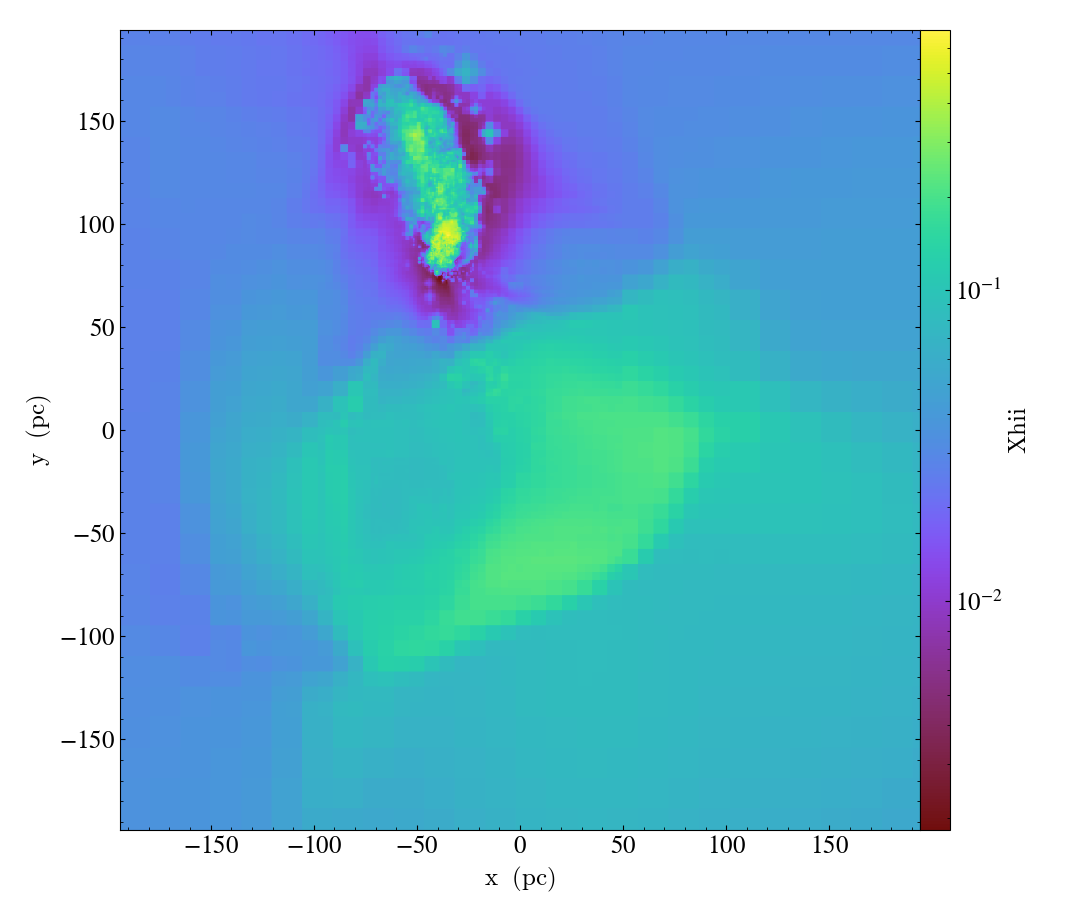

In [421]:
yt.ProjectionPlot(
    ds,
    "z",
    ("ramses", "xHII"),
    width=0.0001,
    weight_field=("gas", "number_density"),
    buff_size=(1000, 1000),
    center=[0.49118094, 0.49275361, 0.49473726]
)

In [422]:
p = yt.ProjectionPlot(ds, "z", ("gas", "number_density"), width=0.0001,
                      weight_field=("gas", "number_density"), buff_size=(1000, 1000),
                      center=[0.49118094, 0.49275361, 0.49473726])
# p.annotate_particles(width = (5, "Mpc"))

yt : [INFO     ] 2024-05-29 21:37:15,612 Identified   162/  384 intersecting domains (  385 through hilbert key indexing)
yt : [INFO     ] 2024-05-29 21:37:18,279 Projection completed
yt : [INFO     ] 2024-05-29 21:37:18,280 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-05-29 21:37:18,280 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-05-29 21:37:18,281 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-05-29 21:37:18,282 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-05-29 21:37:18,282 Making a fixed resolution buffer of (('gas', 'number_density')) 1000 by 1000


yt : [INFO     ] 2024-05-29 21:37:18,716 Identified   162/  384 intersecting domains (  385 through hilbert key indexing)
yt : [INFO     ] 2024-05-29 21:37:22,463 Projection completed
yt : [INFO     ] 2024-05-29 21:37:22,472 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-05-29 21:37:22,472 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-05-29 21:37:22,478 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-05-29 21:37:22,479 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-05-29 21:37:22,480 Making a fixed resolution buffer of (('gas', 'temperature')) 1000 by 1000



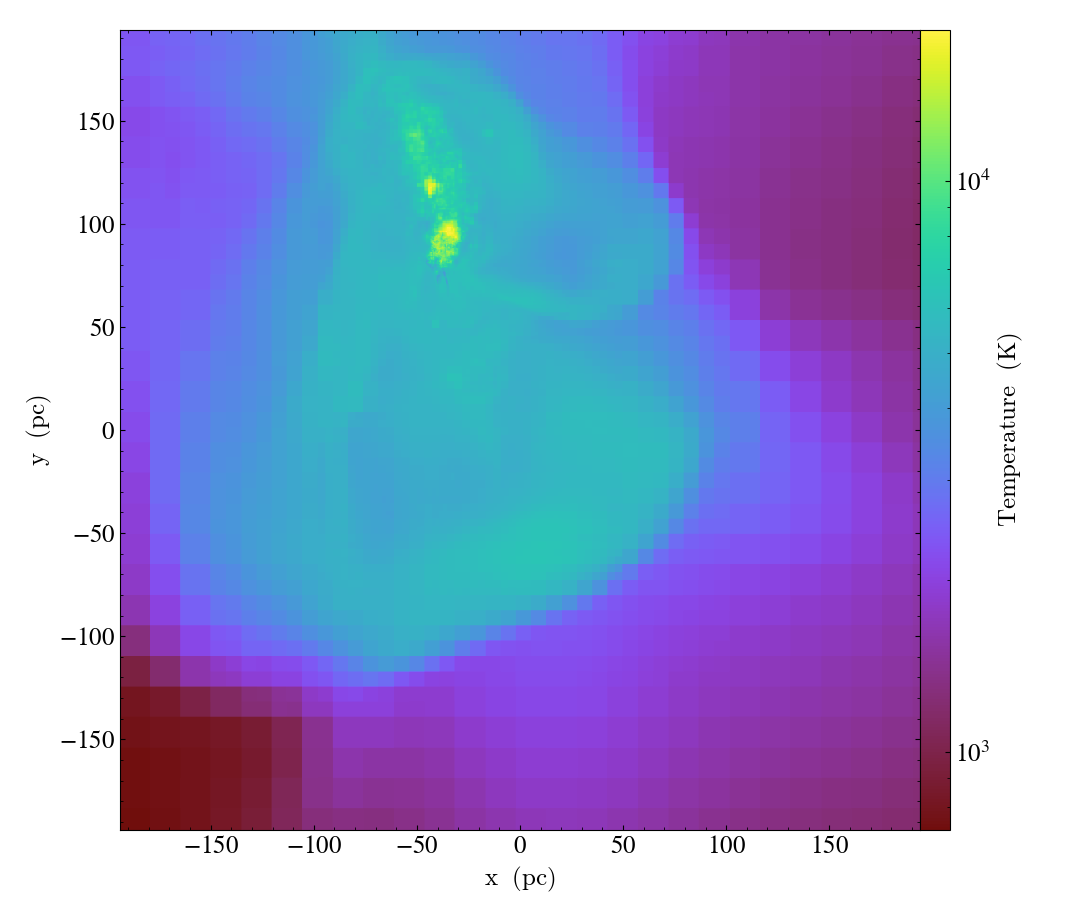

In [423]:
yt.ProjectionPlot(
    ds,
    "z",
    ("gas", "temperature"),
    width=0.0001,
    weight_field=("gas", "number_density"),
    buff_size=(1000, 1000),
    center=[0.49118094, 0.49275361, 0.49473726]
)

yt : [INFO     ] 2024-05-29 21:37:23,089 Identified   162/  384 intersecting domains (  385 through hilbert key indexing)
yt : [INFO     ] 2024-05-29 21:37:26,495 Projection completed
yt : [INFO     ] 2024-05-29 21:37:26,496 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-05-29 21:37:26,496 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-05-29 21:37:26,498 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-05-29 21:37:26,498 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-05-29 21:37:26,499 Making a fixed resolution buffer of (('ramses', 'Metallicity')) 1000 by 1000



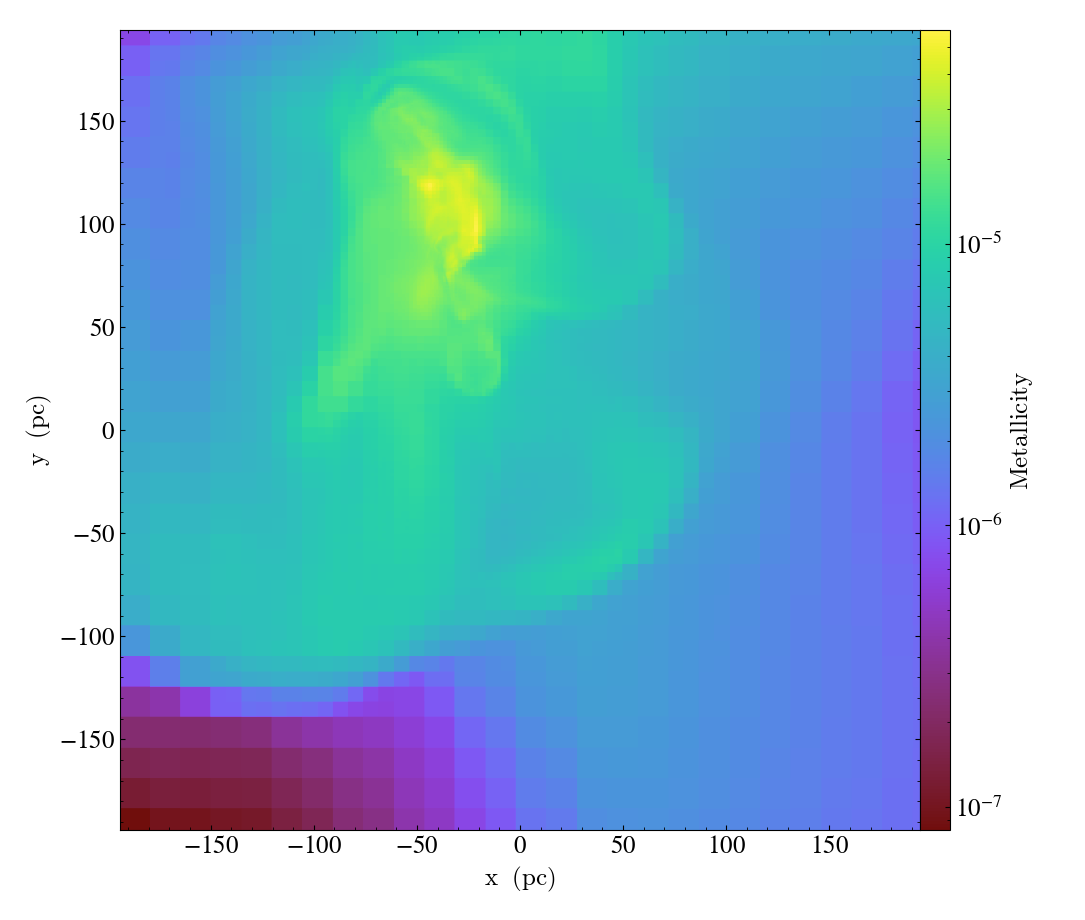

In [424]:
yt.ProjectionPlot(
    ds,
    "z",
    ("ramses", "Metallicity"),
    width=0.0001,
    weight_field=("gas", "number_density"),
    buff_size=(1000, 1000),
    center=[0.49118094, 0.49275361, 0.49473726]
)

yt : [INFO     ] 2024-05-29 21:37:26,816 Identified 39 intersecting domains
yt : [INFO     ] 2024-05-29 21:37:26,878 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-05-29 21:37:26,879 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-05-29 21:37:26,880 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-05-29 21:37:26,880 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-05-29 21:37:26,881 Making a fixed resolution buffer of (('gas', 'number_density')) 1000 by 1000



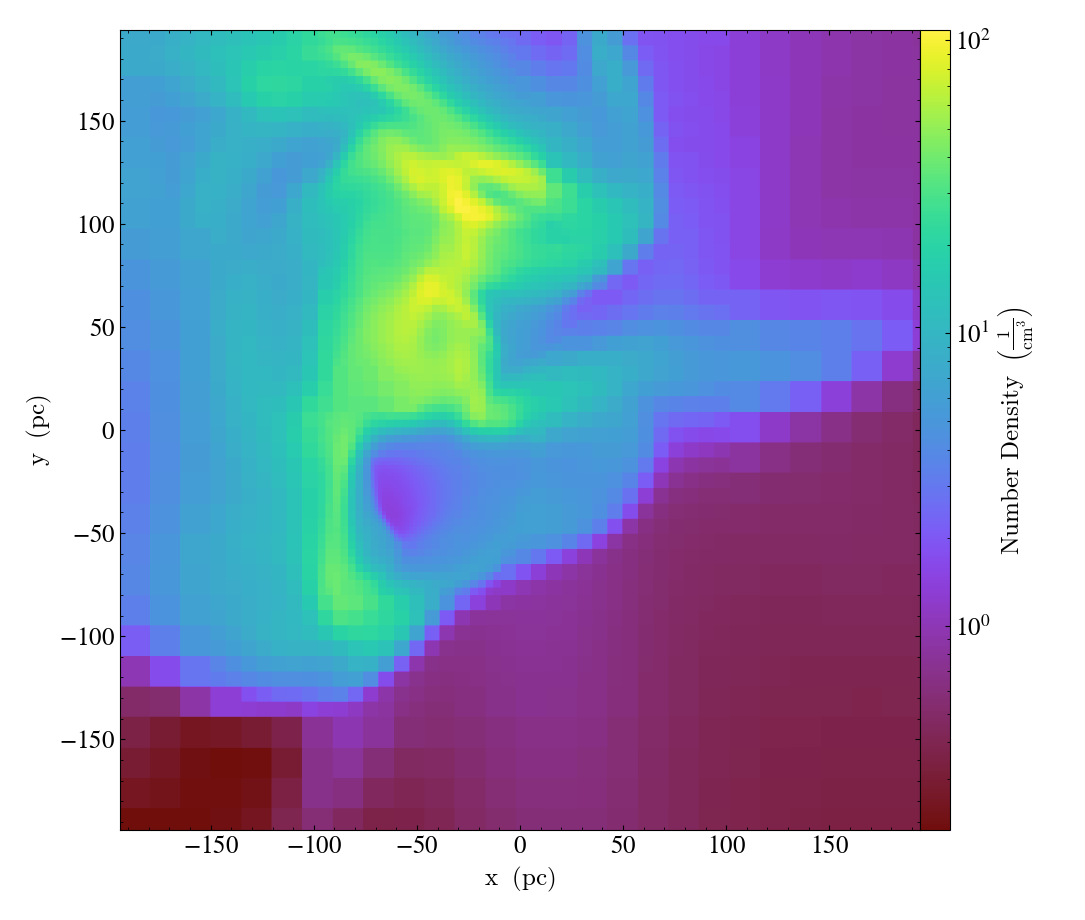

In [425]:
yt.SlicePlot(ds, "z", ("gas", "number_density"), width=0.0001,buff_size=(1000, 1000),center=[0.49118094, 0.49275361, 0.49473726])

yt : [INFO     ] 2024-05-29 21:51:18,974 Identified   162/  384 intersecting domains (  385 through hilbert key indexing)
yt : [INFO     ] 2024-05-29 21:51:21,547 Projection completed
yt : [INFO     ] 2024-05-29 21:51:21,547 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-05-29 21:51:21,548 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-05-29 21:51:21,549 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-05-29 21:51:21,549 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-05-29 21:51:21,549 Making a fixed resolution buffer of (('gas', 'number_density')) 1000 by 1000



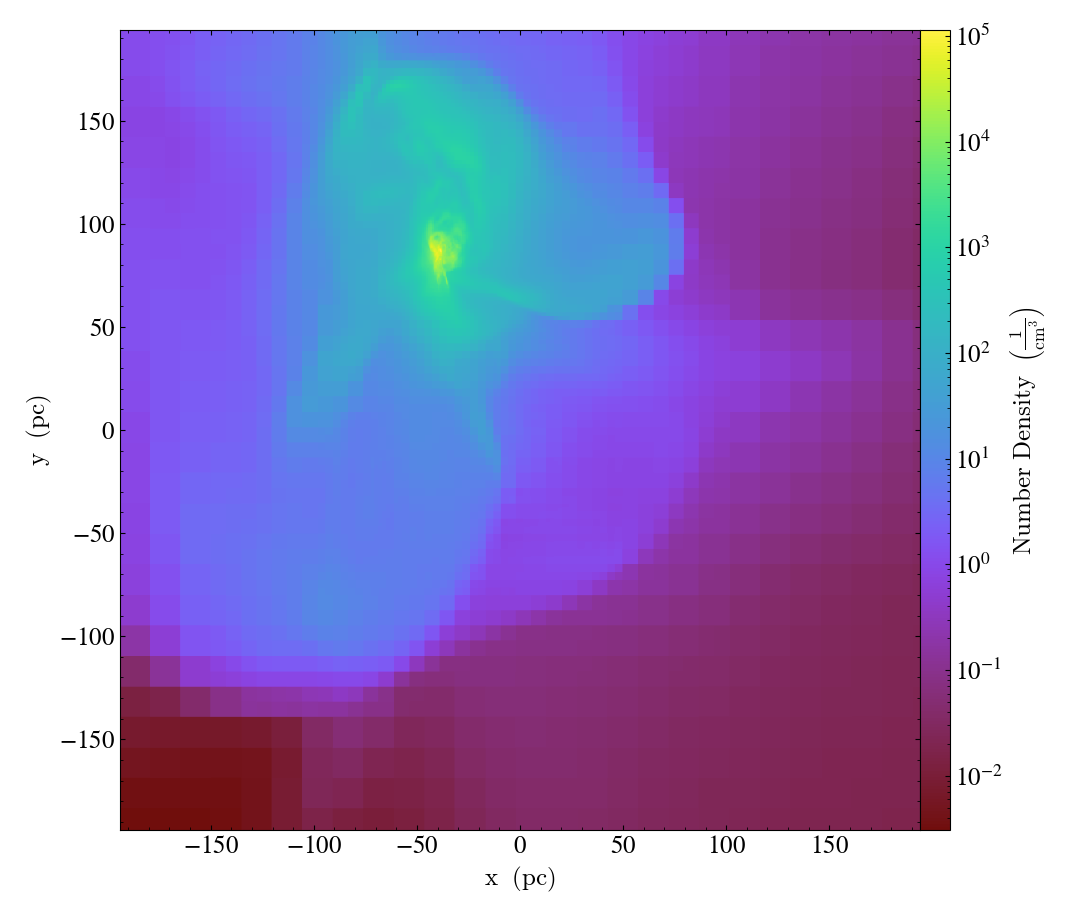

yt : [INFO     ] 2024-05-29 21:51:22,177 Identified   162/  384 intersecting domains (  385 through hilbert key indexing)


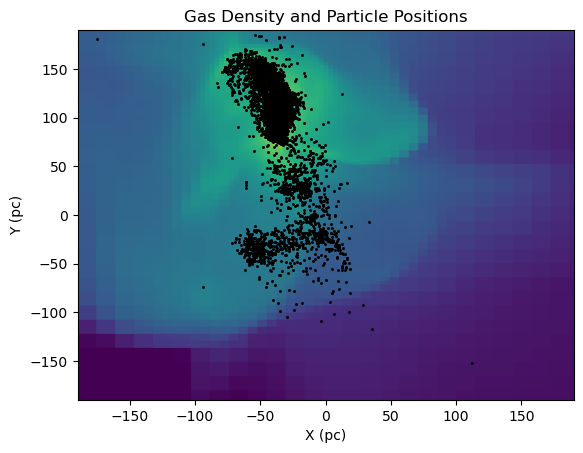

In [437]:
# Define the center for the projection
from matplotlib.colors import LogNorm
# Define the center for the projection
center = [0.49118094, 0.49275361, 0.49473726]
# Create a ProjectionPlot
p = yt.ProjectionPlot(ds, "z", ("gas", "number_density"), width=0.0001,
                      weight_field=("gas", "number_density"), buff_size=(1000, 1000),
                      center=center)
p.show()
p_frb = p.frb  # Fixed-Resolution Buffer from the projection
p_img = np.array(p_frb["gas", "number_density"])
# Extract particle positions
ad = ds.all_data()
particle_positions = ad["star", "particle_position"]
p_c_x = np.array(particle_positions[:, 0]) - center[0]
p_c_y = np.array(particle_positions[:, 1]) - center[1]
p_c_z = np.array(particle_positions[:, 2]) - center[2]
pop2_xyz = np.array(ds.arr(np.vstack([p_c_x, p_c_y, p_c_z]), "code_length").to("pc")).T
# Calculate limits for the plot
lbox = 380  # in pc
extent_dens = [-lbox/2, lbox/2, -lbox/2, lbox/2]
dens_norm = LogNorm(1e-2, 1e5)
# Ensure the aspect ratio of the image matches the scatter plot
plt.imshow(p_img, norm=dens_norm, extent=extent_dens, origin='lower', aspect='auto')
plt.scatter(pop2_xyz[:, 0], pop2_xyz[:, 1], s=5, marker='.', color = 'black')
plt.xlabel("X (pc)")
plt.ylabel("Y (pc)")
plt.title("Gas Density and Particle Positions")
plt.xlim(-lbox/2, lbox/2)
plt.ylim(-lbox/2, lbox/2)
plt.show()

In [440]:
# Finding real size of the box
plot_width = p.width
print(plot_width)

(unyt_quantity(1.e-04, 'code_length'), unyt_quantity(1.e-04, 'code_length'))
